# Simple Variational GP Classification with Pyro

In [1]:
import math
import torch
import gpytorch
import pyro
from matplotlib import pyplot as plt

%matplotlib inline

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


In [2]:
train_x = torch.linspace(0, 1, 50)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))

In [3]:
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import PyroVariationalGP


class PyroGPClassificationModel(PyroVariationalGP):
    def __init__(self, likelihood, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution)
        super(PyroGPClassificationModel, self).__init__(
            variational_strategy, likelihood, num_data=train_y.numel(), name_prefix="basic_gp_test"
        )
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

    
# Initialize model and likelihood
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = PyroGPClassificationModel(likelihood, train_x)

In [4]:
from pyro import optim
from pyro import infer

optimizer = optim.Adam({"lr": 0.01})
elbo = infer.Trace_ELBO(num_particles=256, vectorize_particles=True)
svi = infer.SVI(model.model, model.guide, optimizer, elbo)

In [5]:
num_epochs = 150

for i in range(num_epochs):
    loss = svi.step(train_x, train_y)
    if not (i + 1) % 25:
        print('Iteration {}, Loss = {}'.format(i + 1, loss))

Iteration 25, Loss = 39.51932168006897
Iteration 50, Loss = 26.520130395889282
Iteration 75, Loss = 12.422286748886108
Iteration 100, Loss = 3.070974349975586
Iteration 125, Loss = -6.497781753540039
Iteration 150, Loss = -19.52666473388672


In [6]:
model.eval()
test_x = torch.linspace(0, 1, 200)
pred_dist = model(test_x)

In [7]:
pred_y = likelihood(pred_dist)

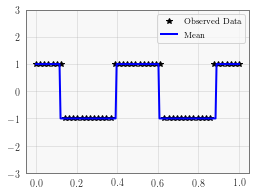

In [8]:
# Initialize fig and axes for plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Get the predicted labels (probabilites of belonging to the positive class)
# Transform these probabilities to be 0/1 labels
pred_labels = pred_y.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])